In [1]:
import yfinance as yf
from sklearn import preprocessing
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
company="AAPL"
interval = 60

In [3]:
stocks = yf.Ticker(company)
df=stocks.history(start='2001-01-19', end='2022-05-13', actions=False)
df=df.drop(['Open','High','Volume','Low'],axis=1)
data=df.values
train_len=math.ceil(len(data)*0.98)
min_max_scalar=preprocessing.MinMaxScaler()
scaled_data=min_max_scalar.fit_transform(data)
train_data=scaled_data[0:train_len,:]
x_train=[]
y_train=[]
for i in range(interval,len(train_data)):
    x_train.append(train_data[i-interval:i,0])
    y_train.append(train_data[i,0])
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
print(x_train.shape)

(5013, 60, 1)


In [4]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
# np.random.seed(4)
# from tensorflow import set_random_seed
# set_random_seed(4)
from keras.callbacks import EarlyStopping,ModelCheckpoint

stop = EarlyStopping(
    monitor='val_loss', 
    mode='min',
    patience=15
)

checkpoint= ModelCheckpoint(
    filepath='./',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

lstm_input = Input(shape=(x_train.shape[1], 1), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
# x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')

In [5]:
model.fit(x=x_train, y=y_train, batch_size=32, epochs=200, shuffle=True, validation_split=0.05, callbacks = [stop, checkpoint])

Epoch 1/200
149/149 [==============================] - 5s 21ms/step - loss: 0.1121 - val_loss: 0.0108
Epoch 2/200
149/149 [==============================] - 3s 17ms/step - loss: 8.4986e-05 - val_loss: 0.0138
Epoch 3/200
149/149 [==============================] - 3s 18ms/step - loss: 7.4023e-05 - val_loss: 0.0128
Epoch 4/200
149/149 [==============================] - 3s 17ms/step - loss: 6.9352e-05 - val_loss: 0.0115
Epoch 5/200
149/149 [==============================] - 3s 18ms/step - loss: 6.2526e-05 - val_loss: 0.0097
Epoch 6/200
149/149 [==============================] - 3s 20ms/step - loss: 6.1653e-05 - val_loss: 0.0090
Epoch 7/200
149/149 [==============================] - 3s 17ms/step - loss: 6.2199e-05 - val_loss: 0.0068
Epoch 8/200
149/149 [==============================] - 3s 17ms/step - loss: 4.6879e-05 - val_loss: 0.0063
Epoch 9/200
149/149 [==============================] - 2s 16ms/step - loss: 5.4823e-05 - val_loss: 0.0039
Epoch 10/200
149/149 [============================

In [6]:
test_data=scaled_data[train_len-interval:,:]
x_test=[]
y_test=data[train_len:,:]
for i in range(interval,len(test_data)):
    x_test.append(test_data[i-interval:i,0])
x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

4/4 [==============================] - 0s 5ms/step - loss: 17655.1367
17655.13671875


In [7]:
predictions=model.predict(x_test)
predictions=min_max_scalar.inverse_transform(predictions)
predictions[0:5]

array([[118.52135],
       [117.77561],
       [118.09629],
       [118.10738],
       [117.40047]], dtype=float32)

c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


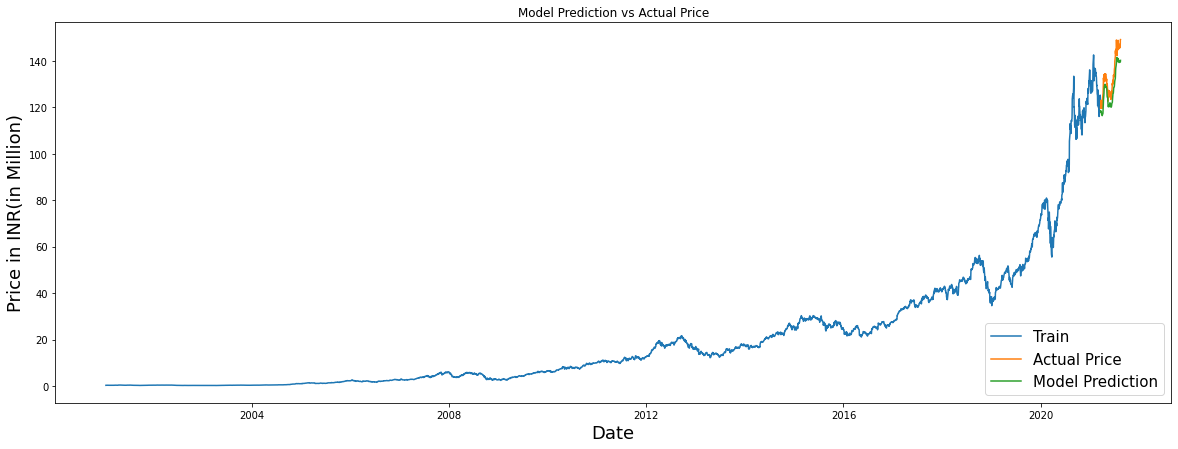

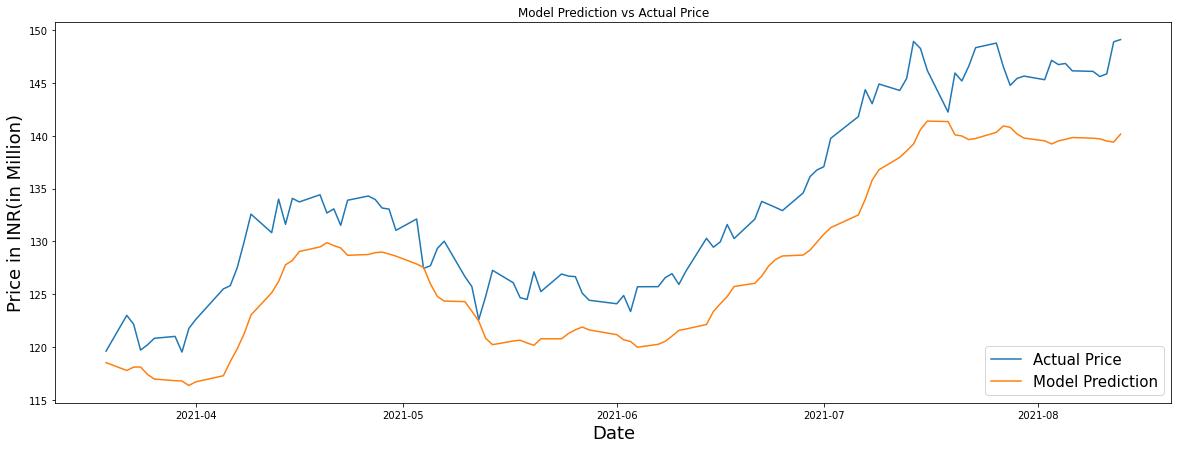

In [8]:
train_data=df[0:train_len]
valid_data=df[train_len:]
valid_data['predictions']=predictions
# valid_data.head()
plt.figure(figsize=(20,7))
plt.title("Model Prediction vs Actual Price")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Price in INR(in Million)",fontsize=18)
plt.plot(train_data['Close'])
plt.plot(valid_data['Close'])
plt.plot(valid_data['predictions'])
plt.legend(['Train','Actual Price','Model Prediction'],loc='lower right',fontsize=15)
plt.show()
plt.figure(figsize=(20,7))
plt.title("Model Prediction vs Actual Price")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Price in INR(in Million)",fontsize=18)
# plt.plot(train_data['Close'])
plt.plot(valid_data['Close'])
plt.plot(valid_data['predictions'])
plt.legend(['Actual Price','Model Prediction'],loc='lower right',fontsize=15)
plt.show()